## Relation Mapping Evaluation

In [1]:
from integration.umls.parser import MetaThesaurusParser
from integration.umls.relationship_mapping import RelationshipMapper
import pandas as pd

In [2]:
from integration.config import load_config

In [3]:
cfg = load_config("../config.ini")

In [4]:
parser = MetaThesaurusParser(
    cache_dir="../cache/umls",
    version=cfg["MetaThesaurusParser"]["version"],
    sab_for_text_lookup=cfg["MetaThesaurusParser"]["sab_for_text_lookup"],
)
mapper = RelationshipMapper(umls_parser=parser, **cfg["RelationshipMapper"])

### Broad2Narrow

In [5]:
import matplotlib.pyplot as plt

plt.style.use("../thesis.mplstyle")

from evaluation.plotting import set_size

In [6]:
from pathlib import Path

PATH_LATEX_PLOT_OUTPUT = Path("../thesis/from_python/figures/relationship_mapping/")
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

In [7]:
from integration.sources.ggponc import _load_ggponc_topic_to_cui_mapping
from tqdm.auto import tqdm

CPG_ID_TO_CUI = _load_ggponc_topic_to_cui_mapping("../topic_to_cui.json")

bench_results = {}
for guideline_id, top_level_cuis in tqdm(CPG_ID_TO_CUI.items()):
    bench_results[guideline_id] = []
    for cui in top_level_cuis:
        res = {}
        concepts, metrics = mapper._get_related_concepts_metrics(
            starting_cui=cui, direction="broad2narrow"
        )
        res["concepts"] = concepts
        res["n_concepts"] = len(concepts)
        res["metrics"] = metrics
        bench_results[guideline_id].append(res)

  0%|          | 0/18 [00:00<?, ?it/s]

In [8]:
df_ggponc_translations = (
    pd.read_csv("../cache/v2.1_2023_03_30/guideline_translations.csv")
    .rename(columns={"id": "guideline_id"})
    .replace("Oesophageal cancer", "Esophageal carcinoma")
)

CPG_ID_TRANSLATIONS = df_ggponc_translations.set_index("guideline_id")[
    "english_name"
].to_dict()

In [9]:
bench_results_metrics = {
    k: [v["metrics"][1:] for v in vs] for k, vs in bench_results.items()
}
bench_results_df = (
    pd.concat(
        [
            pd.DataFrame(vs, index=[k] * len(vs))
            for k, vs in bench_results_metrics.items()
        ]
    )
    .rename(index=CPG_ID_TRANSLATIONS)
    .rename(columns=lambda c: c + 1)
)

In [10]:
bench_results_cuis_new_df = (
    bench_results_df.apply(
        lambda c: c.apply(lambda d: d["n_new_cuis"] if isinstance(d, dict) else 0),
        axis=1,
    )
    .groupby(level=0)
    .sum()
)
bench_results_cuis_referenced_df = (
    bench_results_df.apply(
        lambda c: c.apply(
            lambda d: d["n_referenced_cuis"] if isinstance(d, dict) else 0
        ),
        axis=1,
    )
    .groupby(level=0)
    .sum()
)
bench_results_cuis_related_df = (
    bench_results_df.apply(
        lambda c: c.apply(lambda d: d["n_related_cuis"] if isinstance(d, dict) else 0),
        axis=1,
    )
    .groupby(level=0)
    .sum()
)

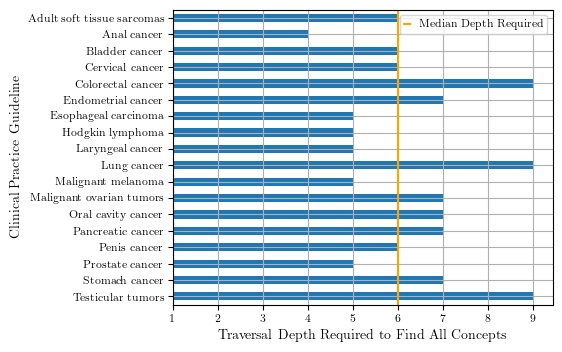

In [11]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

bench_results_cuis_new_df.gt(0).sum(axis=1).sort_index(ascending=False).rename(
    index=CPG_ID_TRANSLATIONS
).plot(
    kind="barh",
    xlabel="Traversal Depth Required to Find All Concepts",
    ylabel="Clinical Practice Guideline",
    ax=ax,
)
ax.axvline(
    [bench_results_cuis_new_df.gt(0).sum(axis=1).median()],
    color="orange",
    label="Median Depth Required",
)
ax.legend(loc="upper right", handlelength=0.5)
ax.set_xlim(1, ax.get_xlim()[1])
ax.grid()
ax.xaxis.set_major_locator(MultipleLocator(1))
fig.savefig(str(PATH_LATEX_PLOT_OUTPUT / "max_depth.pdf"))

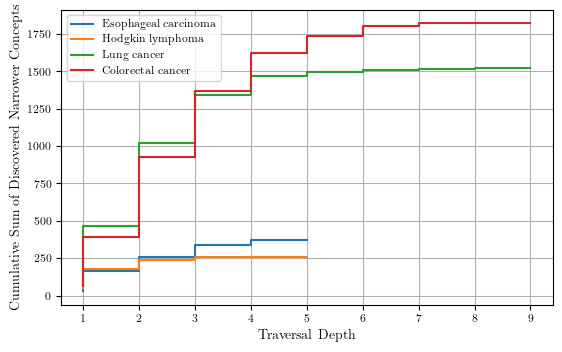

In [12]:
fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
bench_results_cuis_new_df.loc[
    ["Esophageal carcinoma", "Hodgkin lymphoma", "Lung cancer", "Colorectal cancer"]
].replace(0, None).cumsum(axis=1).T.plot(drawstyle="steps-pre", ax=ax)
ax.set_ylabel("Cumulative Sum of Discovered Narrower Concepts")
ax.set_xlabel("Traversal Depth")
ax.grid()
fig.savefig(str(PATH_LATEX_PLOT_OUTPUT / "retrieved_narrow_concepts.pdf"))

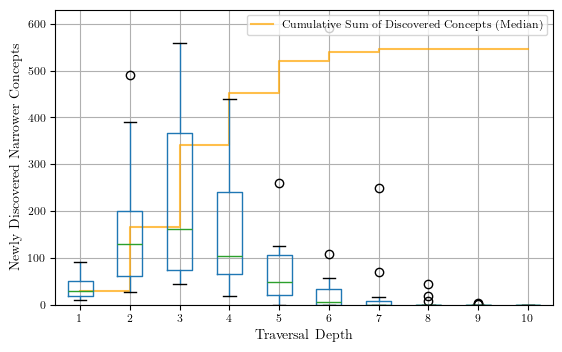

In [13]:
fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

bench_results_cuis_new_df.cumsum(axis=1).median(axis=0).plot(
    ax=ax, drawstyle="steps-post", color="orange", alpha=0.7
)
bench_results_cuis_new_df.boxplot(ax=ax)
ax.set_xlabel("Traversal Depth")
ax.set_ylabel("Newly Discovered Narrower Concepts")
ax.set_ylim(0, 630)
ax.legend(["Cumulative Sum of Discovered Concepts (Median)"], loc="upper right")
fig.savefig(
    str(PATH_LATEX_PLOT_OUTPUT / "new_concepts_depth_distribution_broad2narrow.pdf")
)

### Narrow2Broad

In [21]:
from integration.config import load_config
from integration.db import get_engine
from sqlalchemy import select
from sqlalchemy.orm import sessionmaker

In [22]:
engine = get_engine("sqlite:///../db/data.db")
session = sessionmaker(bind=engine)()

In [23]:
from integration.orm import ggponc
from sqlalchemy import or_

query = (
    select(
        ggponc.Guideline.ggponc_id,
        ggponc.Entity.canonical,
        ggponc.Entity.cui,
        ggponc.Entity.tuis,
    )
    .select_from(ggponc.Guideline)
    .join(ggponc.TextBlock, isouter=True)
    .join(ggponc.Entity, isouter=True)
    .where(ggponc.Guideline.ggponc_id.in_(list(CPG_ID_TO_CUI.keys())))
    .where(
        or_(ggponc.Entity.tuis.contains("T121"), ggponc.Entity.tuis.contains("T061"))
    )
)
res = session.execute(query).all()
df_drugs = (
    pd.DataFrame(res)
    .set_index("ggponc_id")
    .rename(index=CPG_ID_TRANSLATIONS)
    .replace("Oesophageal cancer", "Esophageal carcinoma")
)
df_drugs = (
    df_drugs.reset_index()
    .drop_duplicates(subset=["ggponc_id", "cui"])
    .set_index("ggponc_id")
)

In [24]:
df_drugs["is_drug"] = df_drugs["tuis"].apply(lambda tuis: "T121" in tuis)
df_drugs["is_procedure"] = df_drugs["tuis"].apply(lambda tuis: "T061" in tuis)
df_drugs["type"] = df_drugs.apply(
    lambda r: "Pharmacologic Substance"
    if r["is_drug"]
    else "Therapeutic or Preventive Procedure",
    axis=1,
)

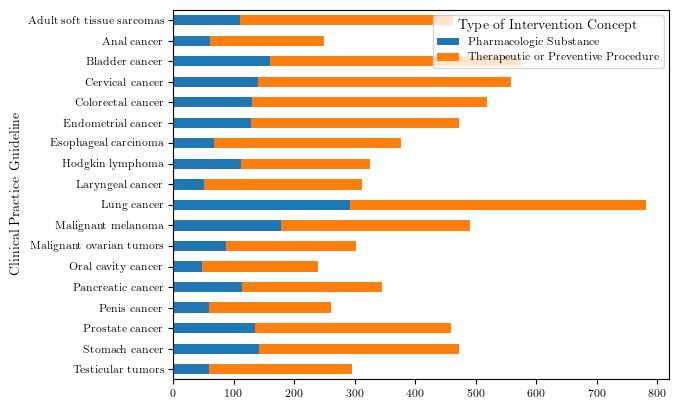

In [25]:
df_drugs.groupby(["ggponc_id", "type"]).size().unstack().rename_axis(
    columns={"type": "Type of Intervention Concept"},
    index="Clinical Practice Guideline",
).sort_index(ascending=False).plot(kind="barh", stacked=True);

In [26]:
df_drugs["cui"].nunique()

3278

In [27]:
bench_results = {}
for cui in tqdm(df_drugs.cui.unique()):
    concepts, metrics = mapper._get_related_concepts_metrics(
        starting_cui=cui, direction="narrow2broad"
    )
    bench_results[cui] = {
        "concepts": concepts,
        "n_concepts": len(concepts),
        "metrics": metrics,
    }

  0%|          | 0/3278 [00:00<?, ?it/s]

In [28]:
df_drugs_search_steps = (
    pd.DataFrame(bench_results).T["metrics"].apply(pd.Series).drop(columns=0)
)

In [29]:
drugs_cuis_new_df = df_drugs_search_steps.apply(
    lambda c: c.apply(lambda d: d["n_new_cuis"] if isinstance(d, dict) else 0),
    axis=1,
)
drugs_cuis_referenced_df = df_drugs_search_steps.apply(
    lambda c: c.apply(lambda d: d["n_referenced_cuis"] if isinstance(d, dict) else 0),
    axis=1,
)
drugs_cuis_related_df = df_drugs_search_steps.apply(
    lambda c: c.apply(lambda d: d["n_related_cuis"] if isinstance(d, dict) else 0),
    axis=1,
)

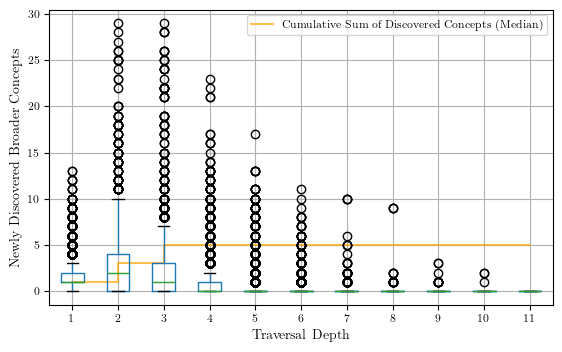

In [30]:
fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

drugs_cuis_new_df.cumsum(axis=1).median(axis=0).plot(
    ax=ax, drawstyle="steps-post", color="orange", alpha=0.7
)
drugs_cuis_new_df.boxplot(ax=ax)
ax.set_xlabel("Traversal Depth")
ax.set_ylabel("Newly Discovered Broader Concepts")
ax.legend(["Cumulative Sum of Discovered Concepts (Median)"], loc="upper right")
fig.savefig(
    str(PATH_LATEX_PLOT_OUTPUT / "new_concepts_depth_distribution_narrow2broad.pdf")
)